# Employee attrition dataset Exploration

## Problem Statement:
The objective of this analysis is to identify key insights and provide actionable recommendations for reducing employee attrition in our organization. By analyzing various factors such as age, gender, marital status, business travel frequency, job-related parameters, and financial aspects, we aim to understand the underlying causes and potential solutions for attrition. The findings from this analysis will help inform decision-making and implement targeted strategies to improve employee retention and foster a positive work environment.

## Import Libraries

In [1]:
import os
import json
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## Data Collection

### Get the Data From Kaggle using API

In [2]:
# create the .kaggle directory and an empty kaggle.json file

# Get the user's root directory
root_directory = os.path.expanduser('~')

# Create the directory path
directory_path = os.path.join(root_directory, '.kaggle')

# Create the directory
os.makedirs(directory_path, exist_ok=True)

# Create the file path (kaggle.json)
file_path = os.path.join(directory_path, 'kaggle.json')

# Create the file
open(file_path, 'a').close()

# Set file permissions
os.chmod(file_path, 0o600)

TO SET UP:  
1. Create a Kaggle Account
2. Once created, click on your avatar icon(top right) and click settings in the menu populated
3. Under settings scroll down to API and click create new token
4. Open the downloaded Kaggle.json file to get your username and key

In [3]:
!pip install kaggle

In [4]:
import kaggle
!kaggle datasets download -d thedevastator/employee-attrition-and-factors

100%|███████████████████████████████████████| 50.1k/50.1k [00:00<00:00, 206kB/s]
100%|███████████████████████████████████████| 50.1k/50.1k [00:00<00:00, 206kB/s]


### Load to DataFrame

In [5]:
# Extract from zip
zip = ZipFile("employee-attrition-and-factors.zip", 'r')
zip.extractall()

In [6]:
# Read into Pandas DataFrame
data = pd.read_csv('HR_Analytics.csv.csv')

## Exploratory Data Analysis

In [7]:
data.shape

(1470, 35)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [9]:
data.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [10]:
## Low cardinality Features
data.nunique()[data.nunique()<2]

EmployeeCount    1
Over18           1
StandardHours    1
dtype: int64

In [11]:
## High Cardinality Features
data.nunique()[data.nunique()>50]

DailyRate          886
EmployeeNumber    1470
HourlyRate          71
MonthlyIncome     1349
MonthlyRate       1427
dtype: int64

**Observation:**
- Employee Number is a high cardinality feature that will be removed before model building as it has potential for bias
- The other features with high cardinality have significant information
- EmployeeCount, Over18, StandardHours are low cardinality features and will also be removed

In [12]:
drop_columns = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']


### 1. What is the distribution of age among the employees in the organization?

In [13]:
min_age = data['Age'].min()
max_age = data['Age'].max()
min_age, max_age

(18, 60)

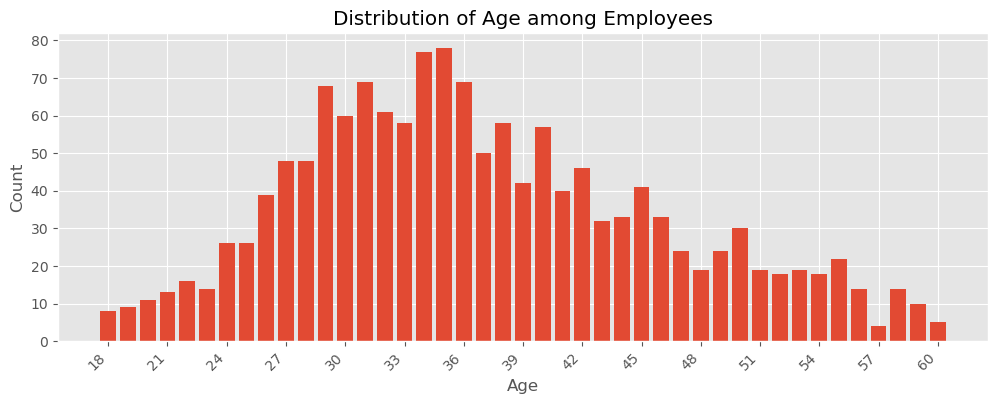

In [14]:
# Define the number of bins and calculate the bin width
num_bins = 10
bin_width = (max_age - min_age) / num_bins

ages = data['Age']

# Calculate the count of each age
unique_ages, counts = np.unique(ages, return_counts=True)

# Plotting the counts per age
plt.figure(figsize=(12,4))
plt.bar(unique_ages, counts)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age among Employees')

# Set x-ticks for every age in the range 18 to 60
plt.xticks(range(18, 61,3), rotation= 45, ha='right')

plt.show()

**Observation:**
- From age 18 to 29, there is an increase in the number of employees increase in age.
- Ages between 29 to around age 40 form the core of the organization with the highest number of employees per age.
- From Age 42 onwards, there is a general decline in number of employees with increase in age.

### 2. Is there a significant difference in attrition rates between male and female employees?

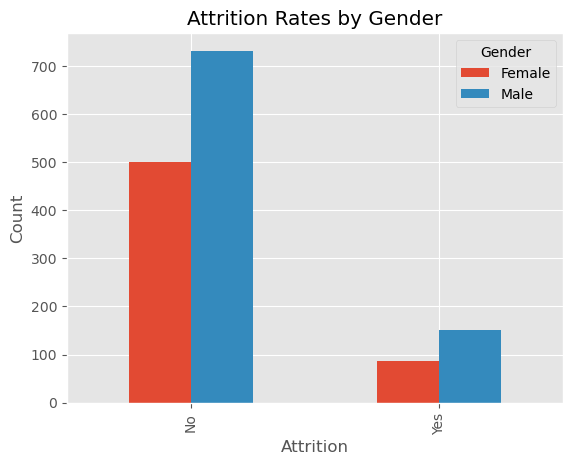

In [15]:
# Create a contingency table of attrition and gender
contingency_table = pd.crosstab(data['Attrition'], data['Gender'])

# Plot the bar chart
contingency_table.plot(kind='bar')

# Set the plot labels and title
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.title('Attrition Rates by Gender')

# Show the plot
plt.show()

**Observation:**
- Based on the bar chart, there is no clear indication that the gender affects attrition

#### Perform Chi-square Test

**<i>H<sub>o</sub></i>** : There is no association between gender and attrition  
**<i>H<sub>o</sub></i>** : There is an association between gender and attrition  
**$\alpha$** = 0.05

In [16]:
# Perform the chi-square test
chi2, p_value, _, _ = st.chi2_contingency(contingency_table, correction=False)

# Print the chi-square test statistic and p-value
print(f"Chi-square test statistic: {chi2:4f}")
print(f"p-value: {p_value:4f}")

Chi-square test statistic: 1.275216
p-value: 0.258790


**Conclusion:**
- The p-value of 0.258 is greater than 0.05, hence we fail to reject the null hypothesis that the 2 variables are independent and conclude that there is no systemic association between the gender and attrition

### 3. How does the distance from home to the office impact employee attrition?

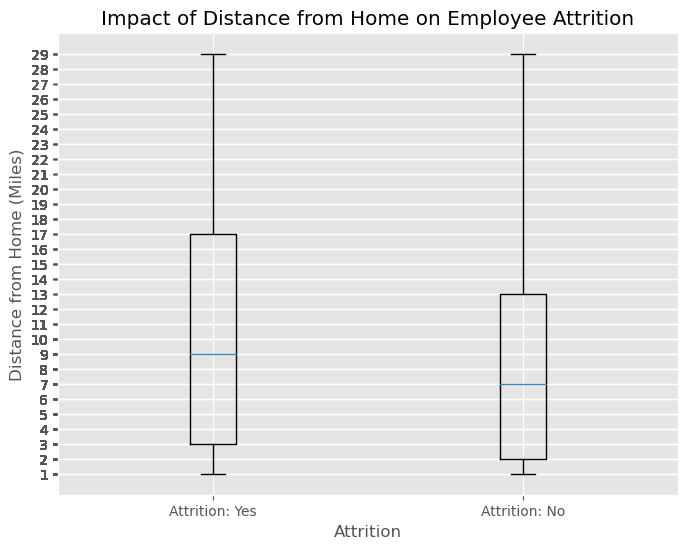

In [17]:
# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot([data[data['Attrition'] == 'Yes']['DistanceFromHome'], data[data['Attrition'] == 'No']['DistanceFromHome']], labels=['Attrition: Yes', 'Attrition: No'])
plt.xlabel('Attrition')
plt.ylabel('Distance from Home (Miles)')
plt.title('Impact of Distance from Home on Employee Attrition')
plt.yticks(data['DistanceFromHome'], data['DistanceFromHome'])
plt.show()

**Observation:**
- There is a slight difference in the mean distance from home for the difference attrition outcomes, with YES having 9 and NO 7
- Both groups have a minimum distance value of 1 mile and a maximum value of 29 miles
- The first quartile values have only one mile separating them with YES at 3 and NO at 2
- There is a huge difference in the third quartile with YES at 17 and NO 13

#### Perform T-Test

We perform a T-Test for YES and NO groupings to check for a difference in the distance from home   
    **<i>H<sub>o</sub></i>** : There is no difference in distance from home for the difference attrition outcomes  
    **<i>H<sub>a</sub></i>** : There is a difference in distance from home for the difference attrition outcomes  
    **$\alpha$** = 0.05

In [18]:
# Subset the data for each group
attrition_yes = data[data['Attrition'] == 'Yes']['DistanceFromHome']
attrition_no = data[data['Attrition'] == 'No']['DistanceFromHome']

# Perform the t-test
t_stat, p_value = st.ttest_ind(attrition_yes, attrition_no, equal_var=False) ## equal_var = False due to data imbalance

# Print the t-statistic and p-value
print(f"T-Statistic: {t_stat:4f}")
print(f"P-Value: {p_value:4f}")

T-Statistic: 2.888183
P-Value: 0.004137


**Conclusion:**
- A p_value of 0.004137 is less than 0.05, thus we reject the null hypothesis and accept the alternate hypothesis
- Hence, there is a difference in distance from home for the difference attrition outcomes

#### Pearsonr to Identify nature of relationship

**<i>H<sub>o</sub></i>** : There is no connection between the distance from home and the attrition outcome  
**<i>H<sub>a</sub></i>** : There is a connection between the distance from home and the attrition outcome   
**$\alpha$** = 0.05

In [19]:
# Set the random seed for reproducibility
np.random.seed(42)

# Determine the size of the downsampled attrition_yes array
downsample_size = len(attrition_yes)

# Randomly select observations from attrition_yes to create the downsampled array
downsampled_attrition_no = np.random.choice(attrition_no, size=downsample_size, replace=False)

# Perform the statistical tests or analysis using the downsampled arrays
correlation, p_value = st.pearsonr(downsampled_attrition_no, attrition_yes)

# Print the correlation coefficient and p-value
print(f"Correlation Coefficient: {correlation:4f}")
print(f"P-Value: {p_value:4f}")

Correlation Coefficient: -0.081399
P-Value: 0.211822


**Conclusion:**
- A p-value of 0.211, greater than 0.05, means that we fail to reject our null hypothesis and conclude that there is not enough evidence to conclude a significant correlation between attrition and distance from home.
- The correlation coefficient of -0.081399 indicates a weak negative correlation, but it is not statistically significant.
- Based on the previous t-test, we identify the presence of a relationship thought the pearson correlation test concludes that this relationship is not statistically significant

**Potential Bias issue:**

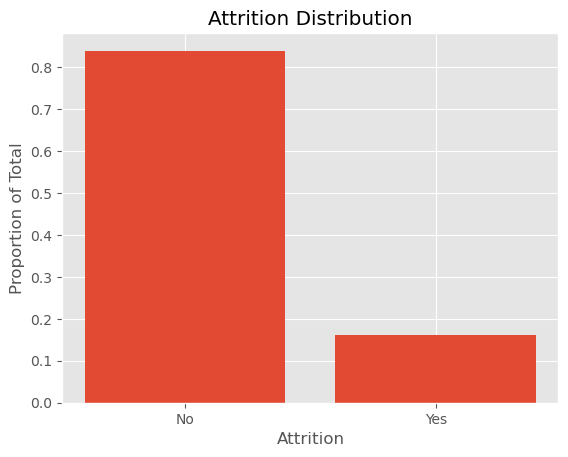

In [20]:
attrition_counts = data['Attrition'].value_counts(normalize=True)

# Create a bar chart
plt.bar(attrition_counts.index, attrition_counts.values)

# Add labels and title
plt.xlabel('Attrition')
plt.ylabel('Proportion of Total')
plt.title('Attrition Distribution')

# Display the plot
plt.show()


- Due to the large imbalance in the two classes in the Attrition variable, The Majority Class was downsampled during calculation of Pearson Correlation.
- Please note that downsampling the data may introduce some uncertainty and potential loss of information due to the reduced sample size. It is important to interpret the results with caution and consider the limitations of downsampling on the analysis.

### 4. What is the relationship between education level and job level within the organization?

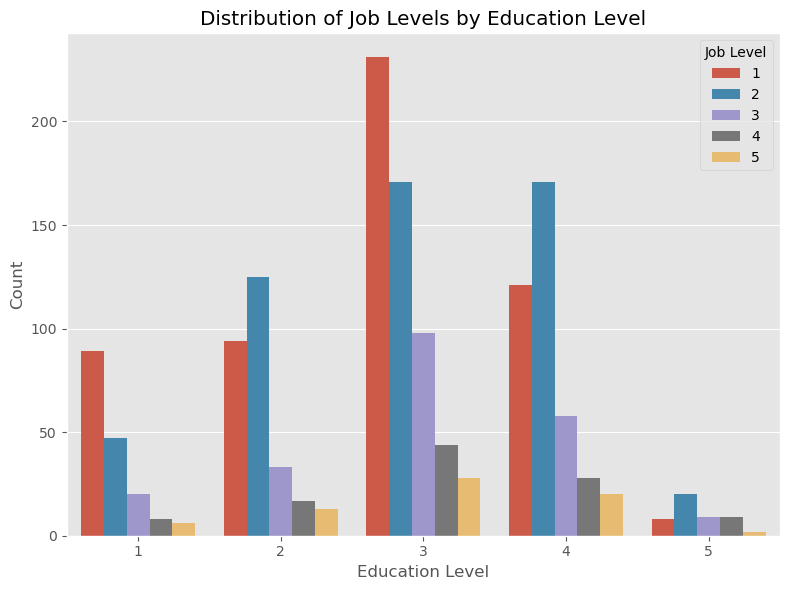

In [21]:
# Create a stacked bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data, x='Education', hue='JobLevel')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Distribution of Job Levels by Education Level')
plt.legend(title='Job Level')
plt.tight_layout()
plt.show()

**Observation:**
- Education level 3 is has the most employees in the various job levels in the company
- Education level 6 has the least employees in the various levels in the company
- Further analysis is required to identify the possible relationship between the two variables

#### Perform Chi-square Test and Cramér's V statistic
**<i>H<sub>o</sub></i>** : There is no association between job level and education  
**<i>H<sub>o</sub></i>** : There is an association between job level and education  
**$\alpha$** = 0.05

In [22]:
# Create a contingency table of education level and job level
contingency_table = pd.crosstab(data['Education'], data['JobLevel'])

# Perform the chi-square test
chi2, p_value, _, _ = st.chi2_contingency(contingency_table)

# Calculate the Cramér's V statistic
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
cramer_v = np.sqrt(phi2 / min((r - 1), (k - 1)))

# Print the test results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Cramér's V statistic: {cramer_v:}")

Chi-square statistic: 61.17582022468589
P-value: 3.3127738726606886e-07
Cramér's V statistic: 0.10200025028704611


**Conclusion:**
- The p-value of 3.313e-07 indicates strong evidence against the null hypothesis of independence. Hence we reject the null hypothesis and accept the alternate hypothesis
- Based on the Cramér's V statistic of 0.102 and the chi-square statistic of 61.176, there is a statistically significant association between education level and job level within the organization.
- The Cramér's V statistic measures the strength of association between categorical variables, while the chi-square statistic tests the independence of these variables. In this case, both statistics suggest that there is a significant relationship between education level and job level.
- The small effect size (Cramér's V = 0.102) indicates a weak practical significance of the association. However, the statistical significance (p-value < 0.05) suggests that the association is unlikely to be due to chance alone.

### 5. Is there a correlation between job satisfaction and monthly income?

#### Perform Pearson Correlation Test
**<i>H<sub>o</sub></i>** : There is no connection between job satisfaction and monthly income  
**<i>H<sub>a</sub></i>** : There is a connection between job satisfaction and monthly income  
**$\alpha$** = 0.05

In [23]:
job_satisfaction = data['JobSatisfaction']
monthly_income = data['MonthlyIncome']

# Calculate correlation coefficient and p-value
correlation, p_value = st.pearsonr(job_satisfaction, monthly_income)

# Print the results
print(f"Correlation Coefficient: {correlation:.4f}")
print(f"P-Value: {p_value:.4f}")

Correlation Coefficient: -0.0072
P-Value: 0.7840


**Conclusion:**
- The p-value of 0.7840 is greater than the alpha value, 0.05.
- Hence, we fail to reject the null hypothesis and conclude that there is no statistically significant relationship between job satisfaction and monthly income.
- The correlation coefficient being close to zero suggests a very weak correlation between job satisfaction and monthly income. However, it is not statistically significant

### 6. Does the number of companies previously worked for have an effect on attrition rates?

#### Perform Chi-square Test and Cramér's V statistic
**<i>H<sub>o</sub></i>** : There is no association between the number of companies previously worked for and attrition   
**<i>H<sub>o</sub></i>** : There is an association between the number of companies previously worked for and attrition  
**$\alpha$** = 0.05

In [24]:
# Create a contingency table
contingency_table = pd.crosstab(data['Attrition'], data['NumCompaniesWorked'])

# Perform the chi-square test
chi2, p_value, _, _ = st.chi2_contingency(contingency_table)

# Calculate the Cramér's V statistic
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
cramer_v = np.sqrt(phi2 / min((r - 1), (k - 1)))

# Print the chi-square statistic and p-value
print(f"Chi-square test statistic: {chi2:4f}")
print(f"p-value: {p_value:4f}")
print(f"Cramér's V statistic: {cramer_v:}")

Chi-square test statistic: 25.744404
p-value: 0.002249
Cramér's V statistic: 0.1323374485313073


**Conclusion:**
- The p-value of 0.002249(less than 0.05) indicates that the observed relationship between the number of companies previously worked for and attrition rates is statistically significant. In other words, the likelihood of observing such an association by chance alone is very low. 
- Therefore, we can reject the null hypothesis that there is no association between these variables.
- The Cramér's value suggests a moderate level of association between the variables.

## 7. What Features have a Significant Impact on Attrition

- Modelling will be used to answer this question  
- Due the focus is on explainability of the model, logistic regression and tree based models will be explored  
- This is because this models allow to extract feature importances helping to drive decision making
- My focus will be on the 5 most positive features and the 5 most negative features
- Based on the result, further analysis may be done in order to ensure results given to management are truthful  
- This analysis will occur to also identify potential bias issues
- Due to the small sample size, we will only split the data to train and test set and use grid search for validation

#### Train Test Split

In [25]:
# Make a copy of data
model_df = data.copy()

# Specify target
target = 'Attrition'

# Make target column binary numeric
model_df[target] = np.where(model_df['Attrition'] == 'Yes', 1, 0)

In [26]:
# Shuffle the dataset to randomize the order of samples
shuffled_df = shuffle(model_df, random_state=42)

drop_columns.append(target)
# Separate features and target variable
X = shuffled_df.drop(drop_columns, axis=1) ## Ensure to drop high cardinality Feature
y = shuffled_df[target]

# Split the dataset into train and test sets, maintaining the class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Training Models

#### Logistic Regression

In [27]:
# Create the pipeline
lr_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Set the hyperparameters manually
lr_params= {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear', 'saga']
}

# Create the grid search object
lr_grid = GridSearchCV(lr_pipeline, param_grid=lr_params, scoring='f1', cv=5)

# Fit the grid search to the data
lr_grid.fit(X_train, y_train)

# Get the best model from the grid search
lr_best_model = lr_grid.best_estimator_

# Make predictions on the train set
y_hat_lr = lr_grid.predict(X_train)

# Get Report
lr_report = classification_report(y_train, y_hat_lr, digits=4)

# Print the best parameters and best F1 score
print("Best Parameters:", lr_grid.best_params_)
print(lr_report)

Best Parameters: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'scaler__with_mean': False, 'scaler__with_std': False}
              precision    recall  f1-score   support

           0     0.8978    0.9687    0.9319       989
           1     0.7156    0.4171    0.5270       187

    accuracy                         0.8810      1176
   macro avg     0.8067    0.6929    0.7295      1176
weighted avg     0.8689    0.8810    0.8675      1176



#### Random Forest

In [28]:
# Create the pipeline with Random Forest classifier
rf_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
rf_params = {
    'classifier__n_estimators': range(1,17),
    'classifier__max_depth': range(1,20),
    'classifier__min_samples_split': range(2,5)
}

# Initialize GridSearchCV
rf_grid = GridSearchCV(rf_pipeline, param_grid = rf_params, scoring='f1', cv=6)

# Fit the grid search to the training data
rf_grid.fit(X_train, y_train)

# Get the best model from the grid search
rf_best_model = rf_grid.best_estimator_


# Make predictions on the train set
y_hat_rf = rf_best_model.predict(X_train)

# Print classification report with f1, precision, and recall
rf_report = classification_report(y_train, y_hat_rf, digits=4)

# Print the best parameters and best F1 score
print("Best Parameters:", rf_grid.best_params_)
print(rf_report)

Best Parameters: {'classifier__max_depth': 12, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 12}
              precision    recall  f1-score   support

           0     0.9687    1.0000    0.9841       989
           1     1.0000    0.8289    0.9064       187

    accuracy                         0.9728      1176
   macro avg     0.9843    0.9144    0.9453      1176
weighted avg     0.9736    0.9728    0.9717      1176



#### XGBoost

In [29]:
# Create the pipeline
xg_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
])

# Define the hyperparameter grid
xg_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001]
}

# Create the grid search object
xg_grid = GridSearchCV(xg_pipeline, param_grid=xg_params, scoring='f1', cv=5)

# Fit the grid search to the data
xg_grid.fit(X_train, y_train)

# Get the best model from the grid search
xg_best_model = xg_grid.best_estimator_

# Make predictions on the train set
y_hat_xg = xg_best_model.predict(X_train)

# Print classification report with f1, precision, and recall
xg_report = classification_report(y_train, y_hat_xg, digits=4)

# Print the best parameters and best F1 score
print("Best Parameters:", xg_grid.best_params_)
print(xg_report)

Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       989
           1     1.0000    1.0000    1.0000       187

    accuracy                         1.0000      1176
   macro avg     1.0000    1.0000    1.0000      1176
weighted avg     1.0000    1.0000    1.0000      1176



#### LightGBM

In [30]:
# Create the pipeline
lgb_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier())
])

# Define the hyperparameter grid
lgb_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001]
}

# Create the grid search object
lgb_grid = GridSearchCV(lgb_pipeline, param_grid=lgb_params, scoring='f1', cv=5)

# Fit the grid search to the data
lgb_grid.fit(X_train, y_train)

# Get the best model from the grid search
lgb_best_model = lgb_grid.best_estimator_

# Make predictions on the train set
y_hat_lgb = lgb_best_model.predict(X_train)

# Print classification report with f1, precision, and recall
lgb_report = classification_report(y_train, y_hat_lgb, digits=4)

# Print the best parameters and best F1 score
print("Best Parameters:", lgb_grid.best_params_)
print(lgb_report)

Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       989
           1     1.0000    1.0000    1.0000       187

    accuracy                         1.0000      1176
   macro avg     1.0000    1.0000    1.0000      1176
weighted avg     1.0000    1.0000    1.0000      1176



In [31]:
## Train Scores
# Logistic Regression 
f1_lr = f1_score(y_train, y_hat_lr)
pr_lr = precision_score(y_train, y_hat_lr)
rc_lr = recall_score(y_train, y_hat_lr)

# Random Forest
f1_rf = f1_score(y_train, y_hat_rf)
pr_rf = precision_score(y_train, y_hat_rf)
rc_rf = recall_score(y_train, y_hat_rf)

# XGBoost
f1_xg = f1_score(y_train, y_hat_xg)
pr_xg = precision_score(y_train, y_hat_xg)
rc_xg = recall_score(y_train, y_hat_xg)


# LightGBM
f1_lgb = f1_score(y_train, y_hat_lgb)
pr_lgb = precision_score(y_train, y_hat_lgb)
rc_lgb = recall_score(y_train, y_hat_lgb)

train_scores = pd.DataFrame({
    "models": ['Logistic Regression','Random Forest', 'XGBoost', 'LightGBM'],
    'train_f1': [f1_lr, f1_rf, f1_xg, f1_lgb],
    'train_precision' : [pr_lr, pr_rf, pr_xg, pr_lgb],
    'train_recall' : [rc_lr, rc_rf, rc_xg, rc_lgb]
}).set_index('models')
train_scores

,train_f1,train_precision,train_recall
models,,,
Logistic Regression,0.527027,0.715596,0.417112
Random Forest,0.906433,1.000000,0.828877
XGBoost,1.000000,1.000000,1.000000
LightGBM,1.000000,1.000000,1.000000


### Evaluation on Test Set

#### Making Predictions

In [32]:
y_pred_lr = lr_grid.predict(X_test)
y_pred_rf = rf_grid.predict(X_test)
y_pred_xg = xg_grid.predict(X_test)
y_pred_lgb = lgb_grid.predict(X_test)

#### Evaluation

In [33]:
# Logistic Regression
f1_lr = f1_score(y_test, y_pred_lr)
pr_lr = precision_score(y_test, y_pred_lr)
rc_lr = recall_score(y_test, y_pred_lr)

# Random Forest
f1_rf = f1_score(y_test, y_pred_rf)
pr_rf = precision_score(y_test, y_pred_rf)
rc_rf = recall_score(y_test, y_pred_rf)

# XGBoost
f1_xg = f1_score(y_test, y_pred_xg)
pr_xg = precision_score(y_test, y_pred_xg)
rc_xg = recall_score(y_test, y_pred_xg)


# LightGBM
f1_lgb = f1_score(y_test, y_pred_lgb)
pr_lgb = precision_score(y_test, y_pred_lgb)
rc_lgb = recall_score(y_test, y_pred_lgb)

test_scores = pd.DataFrame({
    "models": ['Logistic Regression','Random Forest', 'XGBoost', 'LightGBM'],
    'test_f1': [f1_lr, f1_rf, f1_xg, f1_lgb],
    'test_precision' : [pr_lr, pr_rf, pr_xg, pr_lgb],
    'test_recall' : [rc_lr, rc_rf, rc_xg, rc_lgb]
}).set_index('models')
test_scores

,test_f1,test_precision,test_recall
models,,,
Logistic Regression,0.631579,0.923077,0.48
Random Forest,0.343750,0.785714,0.22
XGBoost,0.477612,0.941176,0.32
LightGBM,0.450704,0.761905,0.32


#### Combined DataFrame of Train and Test Scores

In [34]:
pd.concat([train_scores, test_scores], axis=1)

,train_f1,train_precision,train_recall,test_f1,test_precision,test_recall
models,,,,,,
Logistic Regression,0.527027,0.715596,0.417112,0.631579,0.923077,0.48
Random Forest,0.906433,1.000000,0.828877,0.343750,0.785714,0.22
XGBoost,1.000000,1.000000,1.000000,0.477612,0.941176,0.32
LightGBM,1.000000,1.000000,1.000000,0.450704,0.761905,0.32


**Observation:**
- XGBoost and LightGBM Models perform best on train set but logistic regression has best f1 score on test set
- Logistic Regression has the best f1 score

### Get Feature Importances from Logistic Regression

#### Results

In [36]:
importances = lr_best_model.named_steps['model'].coef_[0]
feature_names = lr_best_model.named_steps['encoder'].get_feature_names_out()

feature_importance = pd.Series(importances, index=feature_names).sort_values()

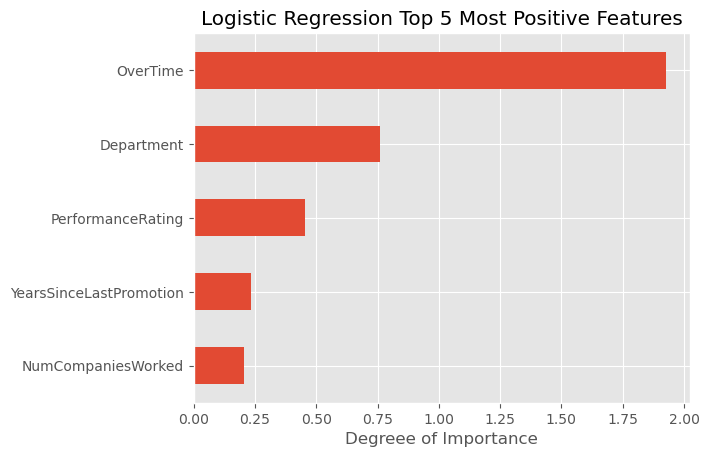

In [37]:
feature_importance.tail().plot(kind = 'barh', 
                                 xlabel = 'Degreee of Importance',
                                 title = 'Logistic Regression Top 5 Most Positive Features'
                                  )
plt.show()

- This features increase likelihood of attrition

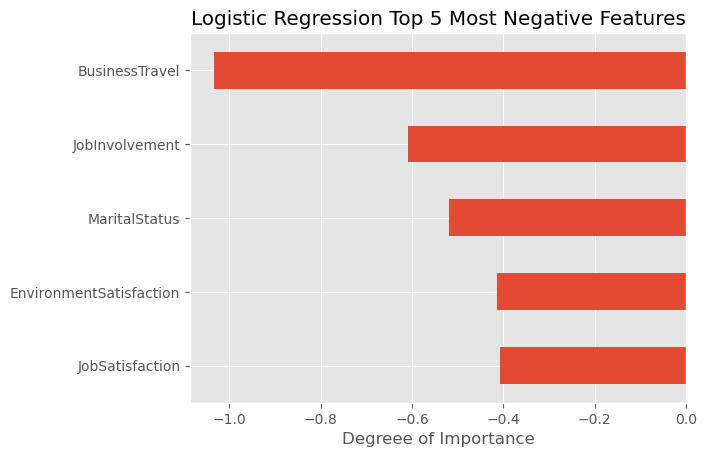

In [38]:
feature_importance.head().sort_values(ascending=False).plot(kind = 'barh', 
                                 xlabel = 'Degreee of Importance',
                                 title = 'Logistic Regression Top 5 Most Negative Features'
                                  )
plt.show()

- This features increase likelihood of retention

### Get Feature Importances from XGBoost model

#### Results

In [39]:
importances_xg = xg_best_model.named_steps['model'].feature_importances_
feature_names_xg = xg_best_model.named_steps['encoder'].get_feature_names_out()

feature_importance_xg = pd.Series(importances_xg, index=feature_names_xg).sort_values()

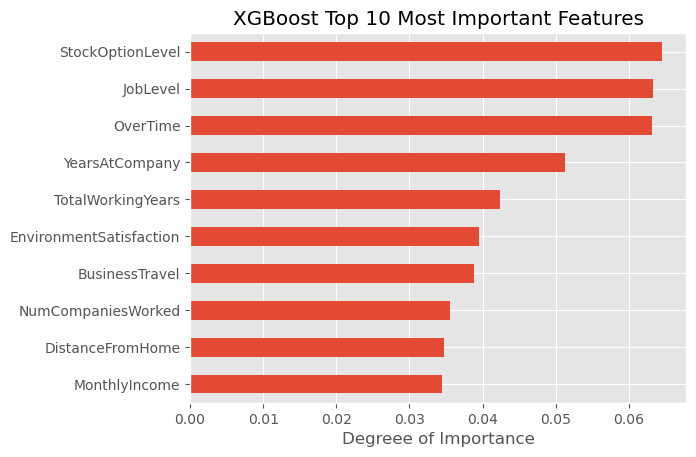

In [40]:
feature_importance_xg.tail(10).plot(kind = 'barh', 
                                 xlabel = 'Degreee of Importance',
                                 title = 'XGBoost Top 10 Most Important Features'
                                  )
plt.show()

### Recommendations:

1. Compensation and Benefits: Considering the significant impact of MonthlyIncome and related factors, it is crucial to ensure competitive compensation packages that align with industry standards. Regular reviews and adjustments to salaries and benefits can help retain employees.

2. Career Progression: Since Age and JobRole was found to influence attrition, establishing clear career progression paths and providing regular opportunities for professional development and advancement can increase employee engagement and loyalty.

3. Employee Engagement: Implementing strategies to enhance overall employee engagement, such as regular feedback mechanisms, open communication channels, and employee wellness programs, can contribute to higher job satisfaction and lower attrition.

4. To address the issue of distance from home and its impact on attrition, the following recommendations can be considered:

    - Flexible Work Arrangements: Introduce flexible work arrangements such as telecommuting or remote work options. Allowing employees to work from home a few days a week can significantly reduce commuting time and expenses, improving their overall work-life balance.

    - Relocation Assistance: Provide relocation assistance or incentives for employees who need to move closer to the office. This can help alleviate the burden of long commutes and make the transition more feasible for employees.

    - Satellite Offices or Remote Work Hubs: Establish satellite offices or remote work hubs in different geographical locations. This allows employees to work from a location closer to their homes, reducing the time and effort required for daily commuting.

    - Commuting Support: Offer commuting support programs such as subsidized public transportation passes or carpooling initiatives. This can help reduce the financial burden and stress associated with long commutes.

    - Employee Housing Assistance: Explore partnerships or programs that provide affordable housing options near the workplace. This can be especially beneficial for employees who face significant challenges in finding suitable housing near the office.

    - Employee Transportation Services: Consider implementing shuttle services or arranging transportation options for employees, especially in areas with limited public transportation access. This can make commuting more convenient and less stressful for employees.
